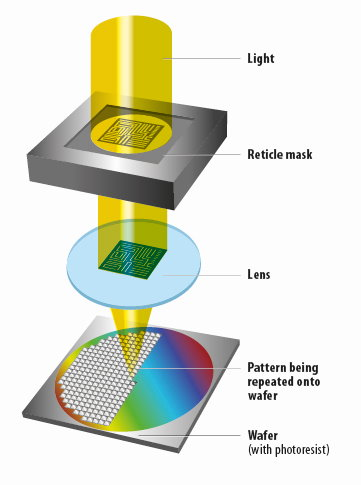

## Task: image(Ideal Pattern)-to-image(Optimized Mask) translation by using GAN model

#### Predicting the optimized intensity (or presence/absence) of each pixel in the mask. This makes the task more akin to regression or direct pixel-wise transformation, where each pixel's output is a continuous value representing its optimized state.

In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms, Resize
from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import StepLR

class LithographyDataset(Dataset):
    def __init__(self, pattern_dir, mask_dir, transform=None):
        self.pattern_dir = pattern_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.patterns = [x for x in os.listdir(pattern_dir) if x.endswith('.png') or x.endswith('.jpg')]
        self.pattern_to_mask = {x: x.replace('.png', 'OPC.png').replace('.jpg', 'OPC.jpg') for x in self.patterns}

    def __len__(self):
        return len(self.patterns)

    def __getitem__(self, idx):
        pattern_filename = self.patterns[idx]
        mask_filename = self.pattern_to_mask[pattern_filename]
        pattern_path = os.path.join(self.pattern_dir, pattern_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        pattern = Image.open(pattern_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            pattern, mask = self.transform(pattern, mask)

        return pattern, mask

def get_transforms(augment=False):
    def transform(pattern, mask):
        if augment:
            # Apply augmentations
            # Resize
            resize = Resize((260, 260))
            pattern = resize(pattern)
            mask = resize(mask)

            # Random crop
            i, j, h, w = transforms.RandomResizedCrop.get_params(
                pattern, scale=(0.8, 1.0), ratio=(0.75, 1.33))
            pattern = F.crop(pattern, i, j, h, w)
            mask = F.crop(mask, i, j, h, w)

            # Random horizontal flipping
            if torch.rand(1) < 0.5:
                pattern = F.hflip(pattern)
                mask = F.hflip(mask)

            # Random vertical flipping
            if torch.rand(1) < 0.5:
                pattern = F.vflip(pattern)
                mask = F.vflip(mask)

            # Random rotation
            angle = transforms.RandomRotation.get_params(degrees=(-15, 15))
            pattern = F.rotate(pattern, angle)
            mask = F.rotate(mask, angle)

            # Random affine
            params = transforms.RandomAffine.get_params(
                degrees=(-10, 10), translate=(0.1, 0.1), scale_ranges=(0.9, 1.1), shears=None, img_size=pattern.size)
            pattern = F.affine(pattern, *params, interpolation=F.InterpolationMode.NEAREST, fill=0)
            mask = F.affine(mask, *params, interpolation=F.InterpolationMode.NEAREST, fill=0)

        # Always apply
        resize = Resize((256, 256))
        pattern = resize(pattern)
        mask = resize(mask)
        pattern = F.to_tensor(pattern)
        mask = F.to_tensor(mask)
        return pattern, mask

    return transform

# Paths to the data
pattern_dir = 'ganopc-data/target/images'
mask_dir = 'ganopc-data/mask/images'

# Initialize the dataset
full_dataset = LithographyDataset(pattern_dir, mask_dir)

# Split dataset into training, validation, and testing sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_test_size = total_size - train_size
train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_test_size])
val_size = int(0.5 * val_test_size) 
test_size = val_test_size - val_size
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Apply transformations
train_dataset.dataset.transform = get_transforms(augment=False)
val_dataset.dataset.transform = get_transforms(augment=False)
test_dataset.dataset.transform = get_transforms(augment=False)

# Creating DataLoaders for each set
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
def check_normalization(data_loader):
    for patterns, masks in data_loader:
        pattern = patterns[0]
        mask = masks[0]
        
        print("Pattern - Min pixel value:", pattern.min().item())
        print("Pattern - Max pixel value:", pattern.max().item())
        print("Mask - Min pixel value:", mask.min().item())
        print("Mask - Max pixel value:", mask.max().item())
        break

check_normalization(train_loader)

Pattern - Min pixel value: 0.0
Pattern - Max pixel value: 1.0
Mask - Min pixel value: 0.0
Mask - Max pixel value: 1.0


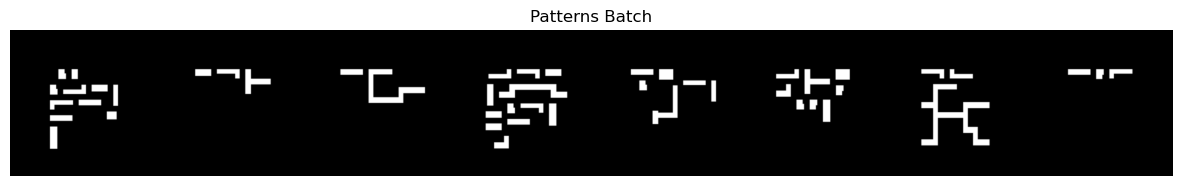

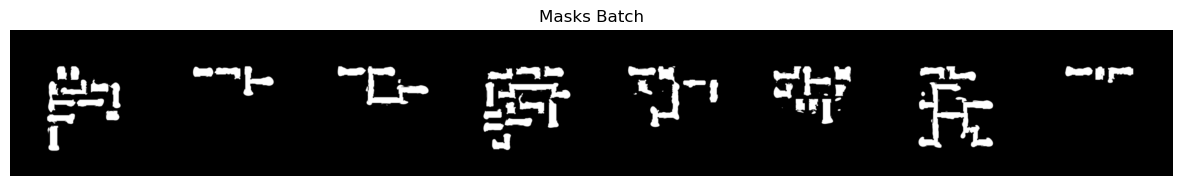

In [3]:
# Function to visualize a batch of images
def show_images_batch(images_batch, title):
    batch_size = len(images_batch)
    grid = make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Visualize one batch of patterns and masks
for patterns, masks in train_loader:
    plt.figure(figsize=(15, 7))
    show_images_batch(patterns, 'Patterns Batch')
    plt.figure(figsize=(15, 7))
    show_images_batch(masks, 'Masks Batch')
    break  # Only show the first batch

In [4]:
class Discriminator(nn.Module):
    """Convolutional discriminator model."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 64 x 128 x 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 1 x 13 x 13
            nn.AdaptiveAvgPool2d(1),  # Reduce to 1 x 1 x 1
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)  # Flatten to [batch_size, 1]
        return x

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW. For padding, calculate the difference of x1 and x2 dimensions.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Generator (UNet)    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.final_activation = nn.Sigmoid()  # output values are in [0, 1]
        #self.final_activation = nn.Tanh()  # Only if your output values are in [-1, 1]

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.final_activation(logits)

In [8]:
# Train GAN function
def train_gan(generator, discriminator, criterion_GAN, criterion_pixelwise, optimizer_G, optimizer_D, train_loader, device, num_epochs=20):
    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        for patterns, masks in train_loader:
            real_masks = masks.to(device)
            patterns = patterns.to(device)
            valid = torch.ones(real_masks.size(0), 1, device=device, dtype=torch.float32)
            fake = torch.zeros(real_masks.size(0), 1, device=device, dtype=torch.float32)

            # ---------------------
            #  Train Generator
            # ---------------------
            optimizer_G.zero_grad()

            # Generate a batch of masks
            fake_masks = generator(patterns)

            # Loss measures generator's ability to fool the discriminator
            pred_fake = discriminator(fake_masks)
            loss_GAN = criterion_GAN(pred_fake, valid)
            # Pixel-wise loss
            loss_pixel = criterion_pixelwise(fake_masks, real_masks)
            # Total loss
            loss_G = 0.1 * loss_GAN + 0.9 * loss_pixel

            loss_G.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Real loss
            pred_real = discriminator(real_masks)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake loss
            pred_fake = discriminator(fake_masks.detach())
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optimizer_D.step()

        print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}] [Pixel-wise loss: {loss_pixel.item()}]")
        
    print("Training complete.")

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = UNet(n_channels=1, n_classes=1).to(device)
discriminator = Discriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_pixelwise = nn.MSELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [10]:
# Train the GAN
num_epochs = 20
train_gan(generator, discriminator, criterion_GAN, criterion_pixelwise, optimizer_G, optimizer_D, train_loader, device, num_epochs)

[Epoch 1/20] [D loss: 0.00031842768657952547] [G loss: 0.7908822298049927] [Pixel-wise loss: 0.011066890321671963]
[Epoch 2/20] [D loss: 0.4005920886993408] [G loss: 0.11119667440652847] [Pixel-wise loss: 0.01627981849014759]
[Epoch 3/20] [D loss: 0.9855666756629944] [G loss: 0.5766921639442444] [Pixel-wise loss: 0.013390572741627693]
[Epoch 4/20] [D loss: 0.3001534342765808] [G loss: 0.21338967978954315] [Pixel-wise loss: 0.010605746880173683]
[Epoch 5/20] [D loss: 0.3726212978363037] [G loss: 0.25091543793678284] [Pixel-wise loss: 0.004680597223341465]
[Epoch 6/20] [D loss: 0.48858317732810974] [G loss: 0.10654685646295547] [Pixel-wise loss: 0.007009254302829504]
[Epoch 7/20] [D loss: 0.5904704332351685] [G loss: 0.09717497229576111] [Pixel-wise loss: 0.006277334876358509]
[Epoch 8/20] [D loss: 0.7835181951522827] [G loss: 0.08594729751348495] [Pixel-wise loss: 0.009265044704079628]
[Epoch 9/20] [D loss: 0.6879473328590393] [G loss: 0.10252125561237335] [Pixel-wise loss: 0.0074716517

In [11]:
model_path = 'GAN_lithography_model.pth'
torch.save(generator, model_path)

In [ ]:
# GAN_model = torch.load('GAN_lithography_model.pth')

In [12]:
def evaluate_model(generator, test_loader, criterion):
    generator.eval() 
    total_loss = 0.0
    device = next(generator.parameters()).device
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = generator(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    
    print(f'Test Loss (L2 Metric): {total_loss / len(test_loader.dataset):.4f}')

evaluate_model(generator, test_loader, nn.MSELoss())

Test Loss (L2 Metric): 0.0036


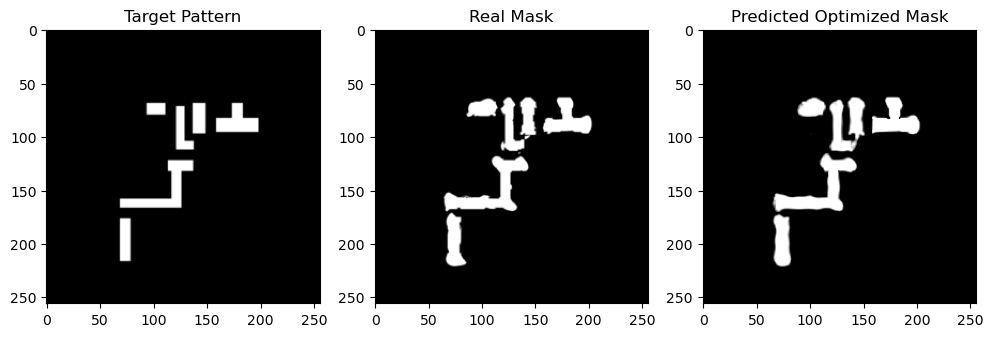

In [13]:
def compare_masks(generator, dataset, num_samples, device='cuda'):
    generator.to(device)
    generator.eval()  # Set the model to evaluation mode
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        pattern, real_mask = dataset[idx]
        pattern = pattern.unsqueeze(0).to(device)  # Add batch dimension and move to device
        real_mask = real_mask.unsqueeze(0).to(device)  # Ensure real_mask also has batch dimension for consistent plotting
        
        with torch.no_grad():  # Inference without tracking gradients
            optimized_mask = generator(pattern)

        # Squeeze to remove the batch dimension and move to CPU for plotting
        pattern = pattern.squeeze(0).cpu()
        real_mask = real_mask.squeeze(0).cpu()
        optimized_mask = optimized_mask.squeeze(0).cpu()

        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(pattern.squeeze().numpy(), cmap='gray')
        axes[0].set_title('Target Pattern')
        axes[1].imshow(real_mask.squeeze().numpy(), cmap='gray')
        axes[1].set_title('Real Mask')
        axes[2].imshow(optimized_mask.squeeze().numpy(), cmap='gray')
        axes[2].set_title('Predicted Optimized Mask')
        plt.savefig("optimized_mask_comparison_GAN.png", dpi=300)
        plt.show()

compare_masks(generator, test_dataset, num_samples=1, device=device)

To check for overfitting in the context of training a Generative Adversarial Network (GAN), you'll need to monitor the behavior of both the generator and discriminator losses over time. Overfitting in GANs can manifest differently than in traditional supervised learning models, but there are still some signs you can look out for.

* Monitoring Losses
Discriminator Overfitting: If the discriminator becomes too good compared to the generator, you might see its loss go down to near zero, indicating it's almost always correctly identifying real and fake images. This situation can stall the generator's learning because the feedback it receives (gradient from the discriminator) becomes less informative.

* Generator Overfitting: The generator might be overfitting if it starts to produce very similar outputs for different inputs or if it's generating high-quality outputs that perfectly fool the discriminator but don't vary much or don't seem to match the diversity of the real dataset. In terms of loss, you might not see as clear an indicator as with the discriminator, but a generator loss that remains low without corresponding high-quality and diverse outputs can be a sign.

Strategies to Detect and Manage Overfitting
Plot Losses Over Time: Regularly plot both discriminator and generator losses over time. Look for signs where the discriminator loss becomes too low compared to the generator loss, or where the generator loss decreases but the quality/diversity of outputs does not improve.

* Use Validation Data: Although less common in GAN training, you can hold out a set of real images that are not used during training and periodically evaluate the discriminator and generator on this set. For the discriminator, see how well it distinguishes real images from generated ones. For the generator, you can use indirect measures such as inception score or FID (Fréchet Inception Distance) to assess the quality and diversity of generated images.

* Visual Inspection: Regularly inspect the images generated by the GAN during training. Overfitting might be happening if the generator produces very similar images across different batches or fails to capture the diversity of the training data.

* Early Stopping: If you observe signs of overfitting, consider implementing early stopping. This involves halting the training when the validation performance starts to worsen, indicating that the model is beginning to memorize the training data rather than learning generalizable patterns.

* Regularization Techniques: Apply regularization techniques to prevent overfitting. For the discriminator, techniques like dropout or adding noise to inputs can help. For the generator, encouraging diversity in generated samples through techniques like minibatch discrimination or feature matching can be beneficial.

* Diversity Measures: Use metrics designed to measure the diversity of the generated images, such as diversity score or coverage metrics. These can give you a quantitative way to assess whether the generator is overfitting by producing a limited variety of outputs.

